In [1]:
import pandas as pd
import numpy as np
import glob
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
#  Keras preprocessing
from keras.preprocessing.image import ImageDataGenerator

## Please note that this file was run in the Kaggle environment due to computing limitations.

In [2]:
# change the path for different folder locations
folder_path = "../input/face-mask-detection/"
path = folder_path + "annotations/"
path_images =  folder_path +"images/"
data = {"xmin":[], "ymin":[], "xmax":[], "ymax":[], "name":[], "file":[], "width":[], "height":[]}
for anno in glob.glob(path+"/*.xml"):
    tree = ET.parse(anno)
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem): 
                if 'name' in attr.tag:
                    name = attr.text                 
                    data['name']+=[name]
                    data['width']+=[width]
                    data['height']+=[height] 
                    data['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            data['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            data['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            data['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            data['ymax']+=[ymax]

In [3]:
# if file exists, ignore this one

directory = 'cropped_images'
folder_path = '/kaggle/working' # if not in kaggle editor, delete this line
# folder_path = folder_path
path = os.path.join(folder_path,directory)
os.mkdir(path)
data = pd.DataFrame(data)
data['cropped_image'] = data['file']
for i in range(len(data)):
    # find the file path and read images
    image_path = path_images + data['file'].iloc[i] +'.png'
    image = cv2.imread(image_path)
    # set the file name for cropped images
    data['cropped_image'].iloc[i] = data['file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_name = data['cropped_image'].iloc[i]
    # use the bounding box to crop images
    xmin = data['xmin'].iloc[i]; ymin = data['ymin'].iloc[i]
    xmax = data['xmax'].iloc[i]; ymax = data['ymax'].iloc[i]
    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    # Save Cropped Image
    cropped_image_directory = os.path.join(path, cropped_image_name) 
    cv2.imwrite(cropped_image_directory, cropped_image)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
cropped_images = !ls './cropped_images'
# 20% testing data index
random.seed(1234)
test_data_index = random.sample(range(len(cropped_images)), int(len(cropped_images)/5))
test = data.loc[test_data_index]
train = data.loc[~data.index.isin(test_data_index)]

In [5]:
path = path
batch_size = 40
target_size = (100,100)
epochs = 40
seed = 1234
num_train_samples = train.shape[0]
num_test_samples = test.shape[0]

In [6]:
image_generator = ImageDataGenerator(
    validation_split=0.2)
print('Training data')
training_generator = image_generator.flow_from_dataframe(
    rescale=1.0/255.0,
    dataframe=train,
    directory=path,
    x_col="cropped_image",
    y_col="name",
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset="training",
    seed = seed
)
print('Validation data')
validation_generator = image_generator.flow_from_dataframe(
    rescale=1.0/255.0,
    dataframe=train,
    directory=path,
    x_col="cropped_image",
    y_col="name",
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset="validation",
    seed = seed
)
print('Test data')
test_image_gen = ImageDataGenerator()
test_generator = test_image_gen.flow_from_dataframe(
    rescale=1.0/255.0,
    dataframe=test,
    directory=path,
    x_col='cropped_image',
    y_col=None,
    class_mode=None,
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    seed = seed
)

Training data
Found 2607 validated image filenames belonging to 3 classes.
Validation data
Found 651 validated image filenames belonging to 3 classes.
Test data
Found 814 validated image filenames.


In [7]:
IMG_SIZE = 100

In [8]:
# official document: https://keras.io/examples/vision/video_classification/
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
test_video = load_video('../input/face-mask-video/pexels-alan-w-8469243.mp4')
test_video.shape

(1551, 100, 100, 3)

-1

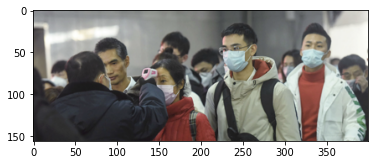

In [10]:
import cv2
import os
import matplotlib.pyplot as plt

  
# Read the input image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss1.png')
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Load the cascade
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(haar_model)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    plt.imshow(cv2.cvtColor(faces, cv2.COLOR_BGR2RGB))
    cv2.imwrite('face.jpg', faces)
      
# Display the output
cv2.imwrite('detcted.jpg', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.waitKey()


Nothing is detected when number of people increases. So we are trying MTCNN and Facenet.

In [11]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.4 MB/s            


In [12]:
!pip install torch_mtcnn

In [13]:
#from mtcnn.mtcnn import MTCNN
from PIL import Image
from torch_mtcnn import detect_faces

img = cv2.imread('../input/face-mask-detection/images/maksssksksss1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_ptl = Image.fromarray(img)
bboxes, results = detect_faces(img_ptl)

Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/pnet-6b6ef92b.pth" to /root/.cache/torch/hub/checkpoints/pnet-6b6ef92b.pth


  0%|          | 0.00/28.1k [00:00<?, ?B/s]

Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/rnet-b13c48bc.pth" to /root/.cache/torch/hub/checkpoints/rnet-b13c48bc.pth


  0%|          | 0.00/394k [00:00<?, ?B/s]

Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/onet-60cc8dd5.pth" to /root/.cache/torch/hub/checkpoints/onet-60cc8dd5.pth


  0%|          | 0.00/1.49M [00:00<?, ?B/s]

-1

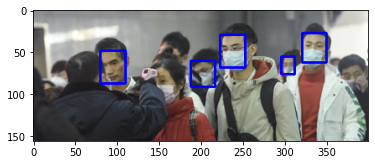

In [14]:
for result in bboxes:
    x,y,w,h,confidence = int(result[0]),int(result[1]),int(result[2]),int(result[3]),result[4]
    cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    plt.imshow(cv2.cvtColor(faces, cv2.COLOR_BGR2RGB))
    cv2.imwrite('face.jpg', faces)
# Display the output
cv2.imwrite('detcted.jpg', img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.waitKey()